In [39]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [40]:
NIFTY = pd.read_csv("Database/Pre_Processed_NIFTY50.csv")

### Data Proprocessing

In [41]:
def Dataset(Data, Date):

  Train_Data = Data['Close'][Data['Date'] < Date].to_numpy()
  Data_Train = []
  Data_Train_X = []
  Data_Train_Y = []
  for i in range(0, len(Train_Data), 5):
    try:
      Data_Train.append(Train_Data[i : i + 5])
    except:
      pass

  if len(Data_Train[-1]) < 5:
    Data_Train.pop(-1)
  
  Data_Train_X = Data_Train[0 : -1]
  Data_Train_X = np.array(Data_Train_X)
  Data_Train_X = Data_Train_X.reshape((-1, 5, 1))
  Data_Train_Y = Data_Train[1 : len(Data_Train)]
  Data_Train_Y = np.array(Data_Train_Y)
  Data_Train_Y = Data_Train_Y.reshape((-1, 5, 1))


  Test_Data = Data['Close'][Data['Date'] >= Date].to_numpy()
  Data_Test = []
  Data_Test_X = []
  Data_Test_Y = []
  for i in range(0, len(Test_Data), 5):
    try:
      Data_Test.append(Test_Data[i : i + 5])
    except:
      pass

  if len(Data_Test[-1]) < 5:
    Data_Test.pop(-1)
  
  Data_Test_X = Data_Test[0 : -1]
  Data_Test_X = np.array(Data_Test_X)
  Data_Test_X = Data_Test_X.reshape((-1, 5, 1))
  Data_Test_Y = Data_Test[1 : len(Data_Test)]
  Data_Test_Y = np.array(Data_Test_Y)
  Data_Test_Y = Data_Test_Y.reshape((-1, 5, 1))

  return Data_Train_X, Data_Train_Y, Data_Test_X, Data_Test_Y

### Model

In [42]:
def Model():
  model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
  return model

In [43]:
model = Model()

In [44]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 200)            161600    
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 200)               40200     
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 5)                 255       
                                                                 
Total params: 548,005
Trainable params: 548,005
Non-trai

### Custom Learning Rate

In [8]:
def scheduler(epoch):
  
  if epoch <= 150:
    lrate = (10 ** -5) * (epoch / 150) 
  elif epoch <= 400:
    initial_lrate = (10 ** -5)
    k = 0.01
    lrate = initial_lrate * math.exp(-k * (epoch - 150))
  else:
    lrate = (10 ** -6)
  
  return lrate

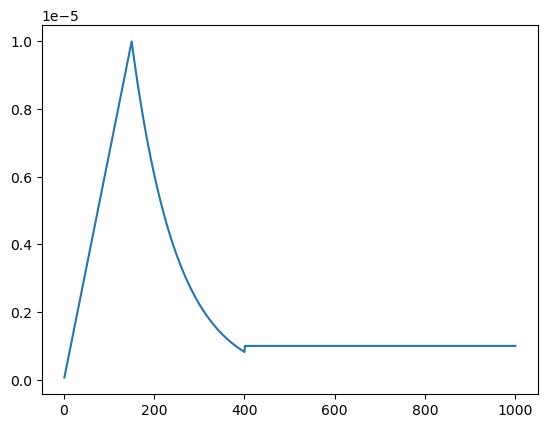

In [9]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [10]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

#NIFTY50

In [11]:
NIFTY.head()

,Unnamed: 0,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr),Volume
0,0,2015-01-01,8272.80,8294.70,8248.75,8284.00,56560411,2321.88,56560411.0
1,1,2015-01-02,8288.70,8410.60,8288.70,8395.45,101887024,4715.72,101887024.0
2,2,2015-01-05,8407.95,8445.60,8363.90,8378.40,118160545,5525.52,118160545.0
3,3,2015-01-06,8325.30,8327.85,8111.35,8127.35,172799618,8089.19,172799618.0
4,4,2015-01-07,8118.65,8151.20,8065.45,8102.10,164075424,7464.33,164075424.0


In [12]:
NIFTY.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380 entries, 0 to 1379
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1380 non-null   int64  
 1   Date               1380 non-null   object 
 2   Open               1380 non-null   float64
 3   High               1380 non-null   float64
 4   Low                1380 non-null   float64
 5   Close              1380 non-null   float64
 6   Shares Traded      1380 non-null   int64  
 7   Turnover (Rs. Cr)  1380 non-null   float64
 8   Volume             1380 non-null   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 97.2+ KB


In [13]:
# Change Dtype of Date column
NIFTY["Date"] = pd.to_datetime(NIFTY["Date"])

###Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26

In [14]:
# NIFTY_Train_Data = NIFTY[NIFTY['Date'] < '2018-12-28']
# NIFTY_Test_Data = NIFTY[NIFTY['Date'] >= '2018-12-28'].reset_index(drop = True)

In [15]:
NIFTY_Date = '2018-12-28'
NIFTY_Train_X, NIFTY_Train_Y, NIFTY_Test_X, NIFTY_Test_Y = Dataset(NIFTY, NIFTY_Date)

In [16]:
NIFTY_Test_X.reshape(-1).shape

(385,)

In [17]:
NIFTY

,Unnamed: 0,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr),Volume
0,0,2015-01-01,8272.80,8294.70,8248.75,8284.00,56560411,2321.88,56560411.0
1,1,2015-01-02,8288.70,8410.60,8288.70,8395.45,101887024,4715.72,101887024.0
2,2,2015-01-05,8407.95,8445.60,8363.90,8378.40,118160545,5525.52,118160545.0
3,3,2015-01-06,8325.30,8327.85,8111.35,8127.35,172799618,8089.19,172799618.0
4,4,2015-01-07,8118.65,8151.20,8065.45,8102.10,164075424,7464.33,164075424.0
...,...,...,...,...,...,...,...,...,...
1375,1375,2020-07-27,11225.00,11225.00,11087.85,11131.80,588148687,34539.73,588148687.0
1376,1376,2020-07-28,11154.10,11317.75,11151.40,11300.55,683891350,38677.47,683891350.0
1377,1377,2020-07-29,11276.90,11341.40,11149.75,11202.85,600726301,38726.02,600726301.0
1378,1378,2020-07-30,11254.30,11299.95,11084.95,11102.15,677761342,39150.44,677761342.0


In [18]:
NIFTY_Date

'2018-12-28'

### Model Fitting

In [19]:
NIFTY_Model = Model()

In [20]:
NIFTY_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [21]:
NIFTY_hist = NIFTY_Model.fit(NIFTY_Train_X, NIFTY_Train_Y, epochs = 1000, validation_data = (NIFTY_Test_X, NIFTY_Test_Y), callbacks=[callback])

Epoch 1/1000
7/7 [==============================] - 2s 73ms/step - loss: 84528208.0000 - root_mean_squared_error: 9193.9229 - val_loss: 122113480.0000 - val_root_mean_squared_error: 11050.4961 - lr: 0.0000e+00
Epoch 2/1000
7/7 [==============================] - 0s 19ms/step - loss: 84527776.0000 - root_mean_squared_error: 9193.8984 - val_loss: 122113504.0000 - val_root_mean_squared_error: 11050.4971 - lr: 6.6667e-08
Epoch 3/1000
7/7 [==============================] - 0s 19ms/step - loss: 84526208.0000 - root_mean_squared_error: 9193.8135 - val_loss: 122111960.0000 - val_root_mean_squared_error: 11050.4277 - lr: 1.3333e-07
Epoch 4/1000
7/7 [==============================] - 0s 17ms/step - loss: 84523440.0000 - root_mean_squared_error: 9193.6631 - val_loss: 122108328.0000 - val_root_mean_squared_error: 11050.2646 - lr: 2.0000e-07
Epoch 5/1000
7/7 [==============================] - 0s 17ms/step - loss: 84519504.0000 - root_mean_squared_error: 9193.4482 - val_loss: 122104376.0000 - val_roo

In [22]:
history_dict = NIFTY_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

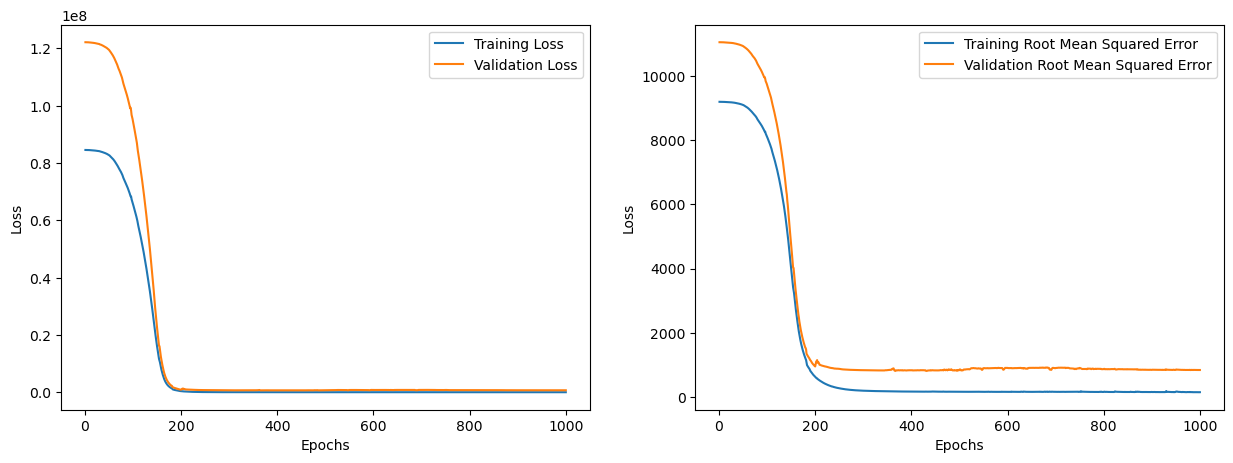

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Apple

In [26]:
NIFTY_prediction = NIFTY_Model.predict(NIFTY_Test_X)

3/3 [==============================] - 0s 5ms/step


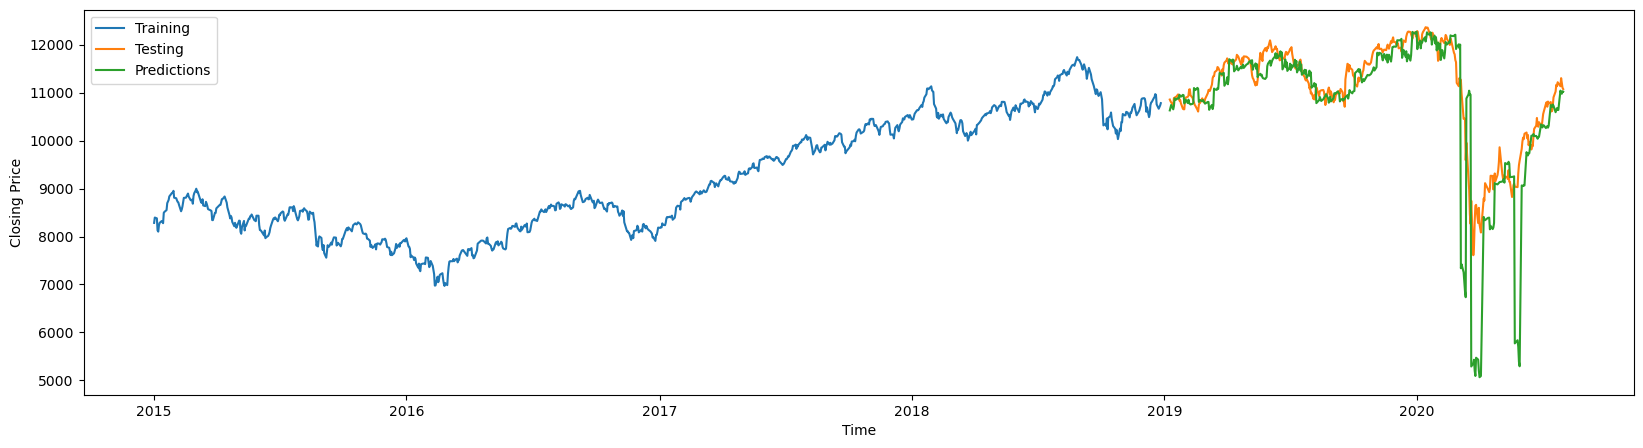

In [34]:
plt.figure(figsize=(20, 5))
plt.plot(NIFTY['Date'][NIFTY['Date'] < '2018-12-28'], NIFTY['Close'][NIFTY['Date'] < '2018-12-28'], label = 'Training')
plt.plot(NIFTY['Date'][NIFTY['Date'] >= '2019-01-09'], NIFTY['Close'][NIFTY['Date'] >= '2019-01-09'], label = 'Testing')
plt.plot(NIFTY['Date'][NIFTY['Date'] >= '2019-01-09'], NIFTY_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')


In [35]:
# plt.figure(figsize=(20, 5))
# plt.plot(NIFTY['Date'][NIFTY['Date'] < '2020-10-12'], NIFTY['Cose'][NIFTY['Date'] < '2020-10-12'], label = 'Training')
# plt.plot(NIFTY['Date'][NIFTY['Date'] >= '2020-10-09'], NIFTY['Close'][NIFTY['Date'] >= '2020-10-09'], label = 'Testing')
# plt.plot(NIFTY['Date'][NIFTY['Date'] >= '2020-10-12'], NIFTY_prediction.reshape(-1), label = 'Predictions')
# plt.xlabel('Time')
# plt.ylabel('Closing Price')
# plt.legend(loc = 'best')

In [36]:
rmse = math.sqrt(mean_squared_error(NIFTY_Test_Y.reshape(-1, 5), NIFTY_prediction))
mape = np.mean(np.abs(NIFTY_prediction - NIFTY_Test_Y.reshape(-1, 5))/np.abs(NIFTY_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 837.9265636644934
MAPE: 0.0371323624392096
